# Importing Libraries

In [59]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.family':'Nimbus Roman'})
import random
import time
from json import dump, load

# Initializing Constants

In [2]:
NUM_ROUNDS = 15
CLIENT_RATIO = 0.3
TOTAL_CLIENTS = 100
NUM_CLIENTS = int(CLIENT_RATIO * TOTAL_CLIENTS)
INIT_THRESHOLD = 4.0
EXPECTED_RESPONSE = 0.8

# Importing the NSL-KDD Dataset

In [3]:
X_train = np.load("variables/X_train.npy")
Y_train = np.load("variables/Y_train.npy")

# Distributing the dataset among the clients

In [4]:
div_list = [np.random.randint(3000,6000) for i in range(NUM_CLIENTS)]
origin_list = [np.random.randint(0,125973-6000) for i in range(NUM_CLIENTS)]

In [5]:
client_train_x = []
client_train_y = []

for i in range(NUM_CLIENTS):
  client_train_x.append(X_train[origin_list[i]:origin_list[i]+div_list[i]])
  client_train_y.append(Y_train[origin_list[i]:origin_list[i]+div_list[i]])

# Model Utilities

In [6]:
def create_server_model():
    model = Sequential()
    model.add(Input(shape=(123,)))
    model.add(Dense(256))
    model.add(Dense(512))
    model.add(Dense(5, activation="softmax"))
    return model

In [7]:
def model_cloner(model, learning_rate, optimizer):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    if optimizer=='adam':
        new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

In [8]:
def train_client(num, model, lr):

  new_model = model_cloner(model, lr, 'adam')
  hist = new_model.fit(client_train_x[num], client_train_y[num], epochs=2, batch_size=32)

  return new_model, lr, round(hist.history['loss'][-1], 4)

# Federated Learning

### Training Loop

In [9]:
client_models = list(np.zeros((NUM_CLIENTS)))
arr = list()
arr1 = list()
server_model_norm = create_server_model()
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
serverhist1={
    "loss":[],
    "accuracy":[],
    "time taken":[]
}

for i in range(NUM_ROUNDS):
  print("-----"+str(i)+"---------")
  losses = []
  lr_init = []
  data= []
  serverhist1["time taken"].append(0)
  for j in range(NUM_CLIENTS):
    arr.append(time.time())
    data.append(train_client(j, server_model_norm, 0.0001))

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])
    # time.sleep(2.519+random.random()*3-1.5)
    arr[-1] = time.time()-arr[-1]+2.519+random.random()*3-1.5
    serverhist1["time taken"][-1] = max(serverhist1["time taken"][-1], arr[-1])

  print(arr)
  # Aggregating model
  arr1.append(max(arr))
  sum1=[i*0 for i in client_models[0].get_weights()]
  for i in range(NUM_CLIENTS):
    sum1 = [i+j for i, j in zip(client_models[i].get_weights(), sum1)]
  server_model_norm.set_weights([i/NUM_CLIENTS for i in sum1])
  h=server_model_norm.evaluate(X_train[:5000, :],Y_train[:5000, :])
  serverhist1['loss'].append(h[0])
  serverhist1['accuracy'].append(h[1])

-----0---------
Epoch 1/2
183/183 [==============================] - 1s 1ms/step - loss: 0.6096 - accuracy: 0.8559
Epoch 2/2
183/183 [==============================] - 0s 1ms/step - loss: 0.1923 - accuracy: 0.9556
Epoch 1/2
150/150 [==============================] - 0s 1ms/step - loss: 0.6577 - accuracy: 0.8569
Epoch 2/2
150/150 [==============================] - 0s 1ms/step - loss: 0.2058 - accuracy: 0.9582
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.8456
Epoch 2/2
128/128 [==============================] - 0s 2ms/step - loss: 0.2288 - accuracy: 0.9448
Epoch 1/2
138/138 [==============================] - 0s 1ms/step - loss: 0.6773 - accuracy: 0.8539
Epoch 2/2
138/138 [==============================] - 0s 1ms/step - loss: 0.2171 - accuracy: 0.9475
Epoch 1/2
130/130 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.8452
Epoch 2/2
130/130 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0

### Saving Training Metrics

In [10]:
with open("variables/normal_out.json", "w") as f:
    dump(serverhist1, f, indent=4)

### Loading Training Metrics

In [11]:
with open("variables/normal_out.json", "r") as f:
    serverhist1 = load(f)

### Time Taken per Round

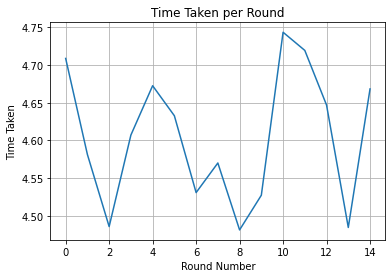

In [12]:
plt.plot(serverhist1["time taken"])
plt.ylabel("Time Taken")
plt.xlabel("Round Number")
plt.title("Time Taken per Round")
plt.grid()
plt.savefig("resources/plainThreshPerRnd.png", dpi=300)
plt.savefig("resources/plainThreshPerRnd.eps", dpi=300)
plt.show()
plt.show()

### Performance of the server model after each round

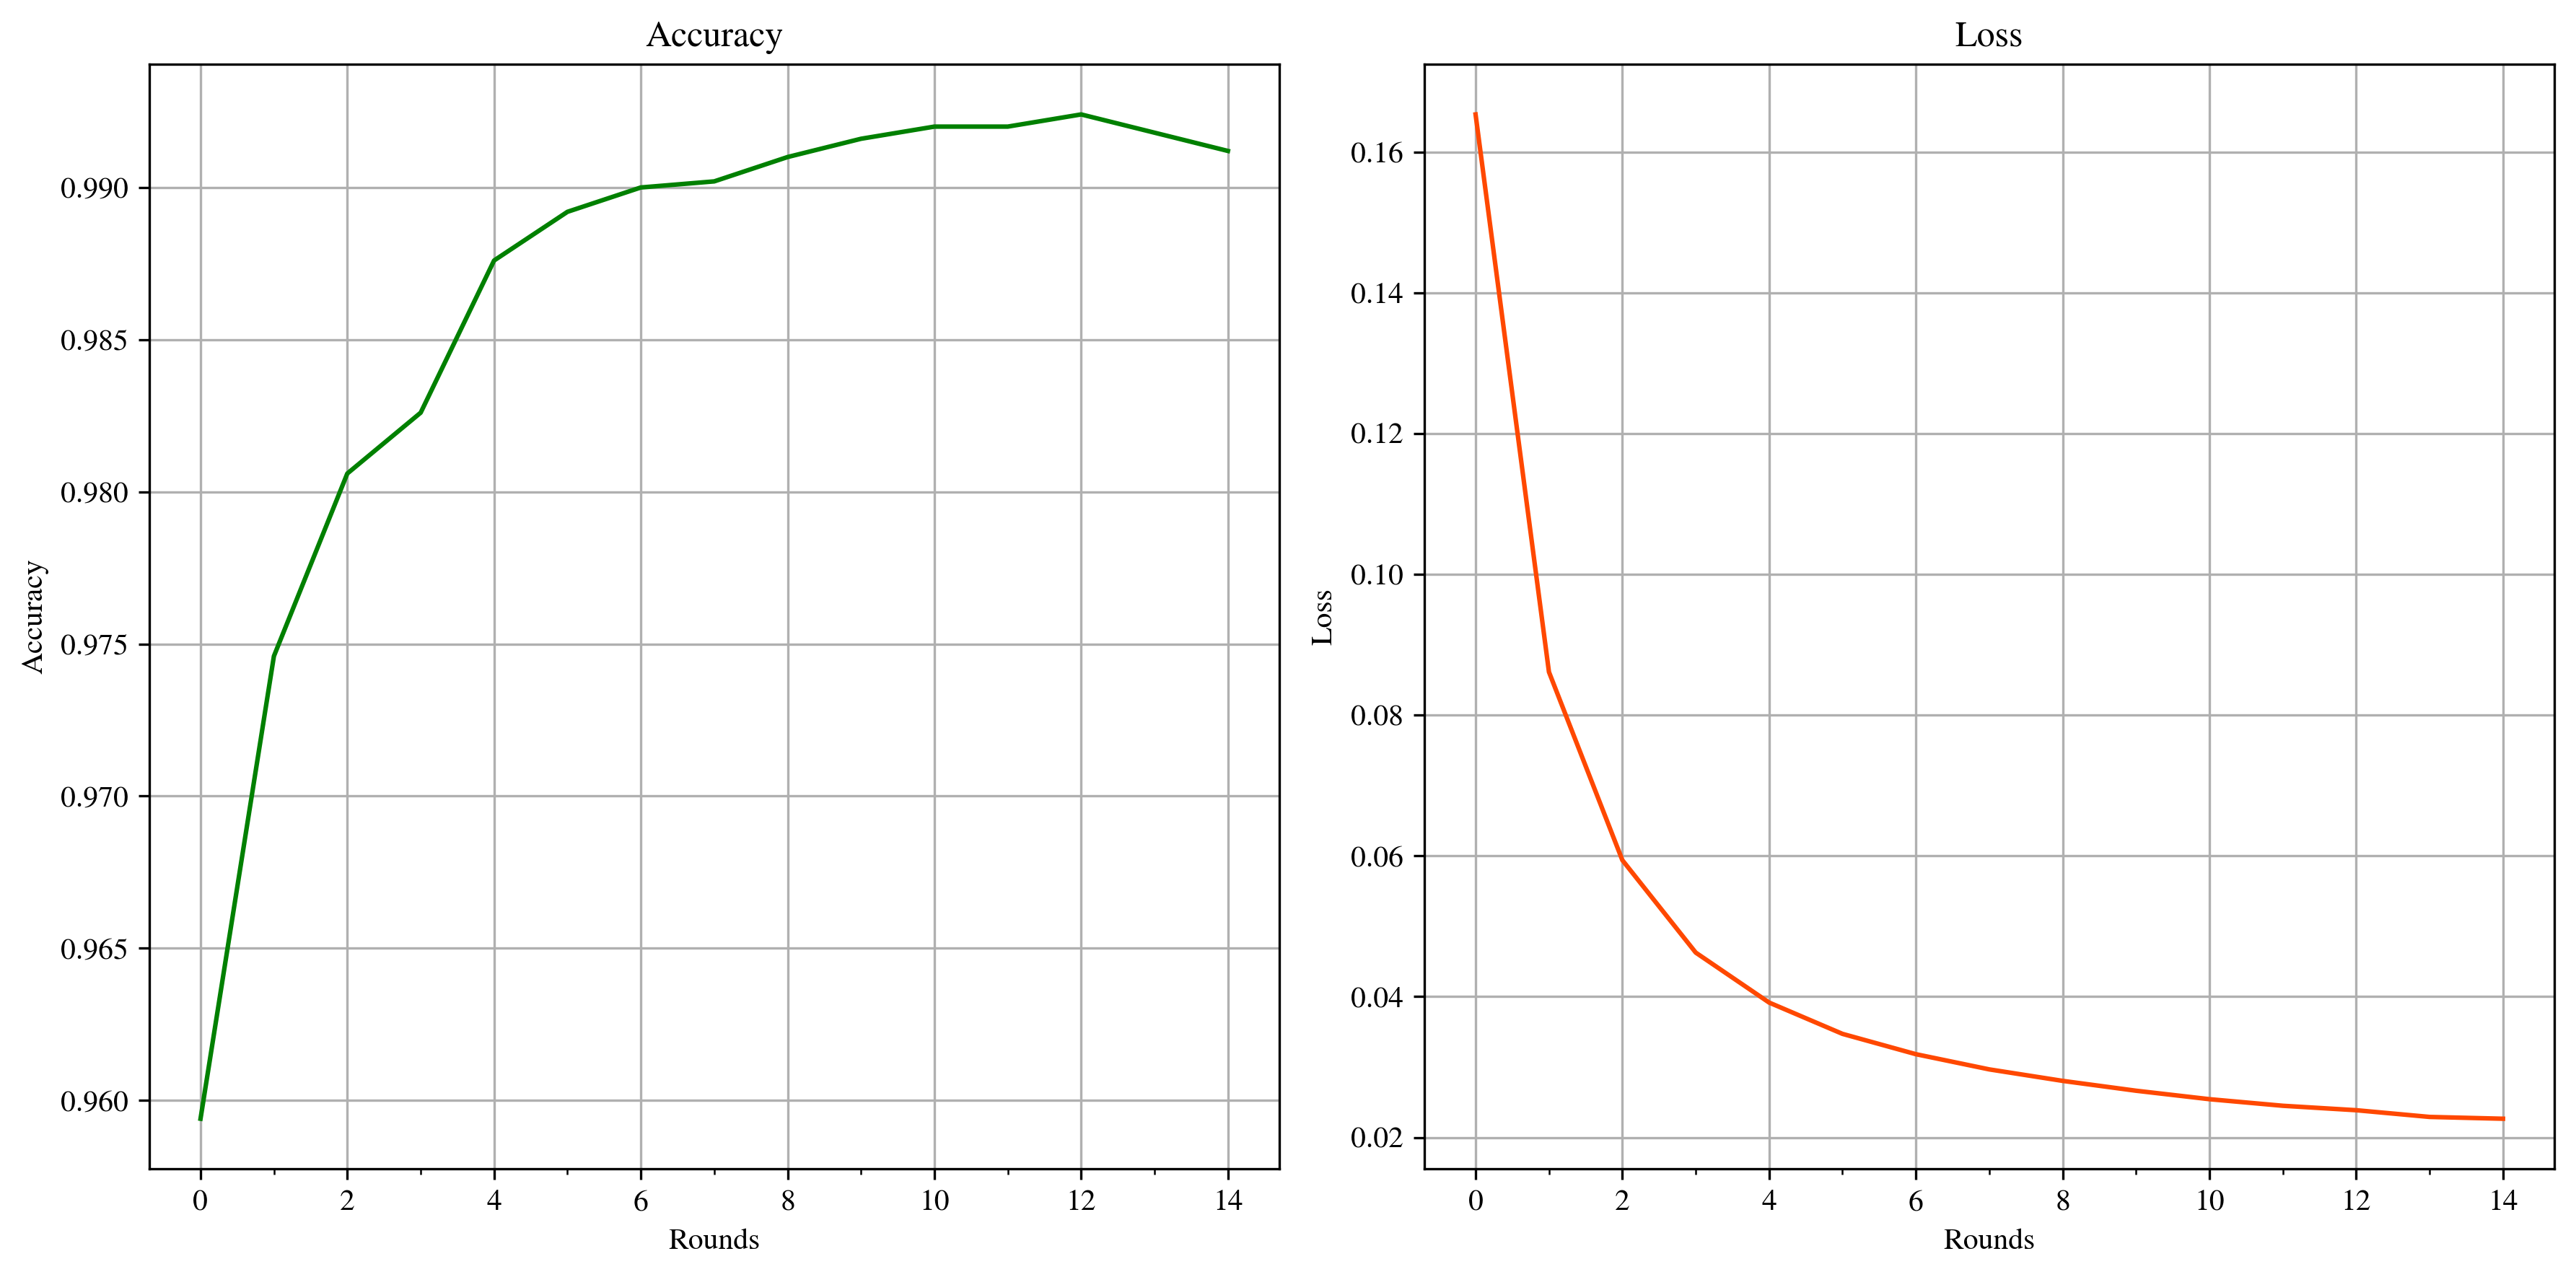

In [68]:
fig = plt.figure(dpi=300, figsize=(12, 6))
ax = fig.add_subplot(121)
ax.plot(serverhist1["accuracy"], color='green')
ax.grid()
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax = fig.add_subplot(122)
ax.plot(serverhist1["loss"], color='#FF4800')
ax.grid()
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Loss")
ax.set_title("Loss")
plt.tight_layout()
plt.savefig("resources/plain_performance.png", dpi=300)
plt.savefig("resources/plain_performance.pdf", dpi=300)
plt.show()

# Temporal Weighted Averaging for Asynchronus Federated Learning

### Training loop

### Variables used
* **client_models** - list of client models
* **server_model_norm** - Server model
* **serverhist** - Training metrics
* **q** - Priority queue of weights (Rank is time)
* **t** - time of execution of clients in queue
* **r** - round number of clients in queue
* **losses** - loss of a particular client in the round
* **lr_init** - learning rate of a particular client in a round
* **data** - client model and training information
* **arr** - time for execution of clinet
* **tr** - total rounds in the queue (under the current threshold)
* **res** - number of clients in the queue from the current round (under the current threshold)
* **c** - number of clients in the queue (under the current threshold)
* **sum1** - sum of weighted weights

In [14]:
client_models = list(np.zeros((NUM_CLIENTS)))
server_model_norm = create_server_model()
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
serverhist={
    "loss":[],
    "accuracy":[],
    "time threshold":[],
    "num processed": []
}
q = list()
t = list()
r = list()
threshold = INIT_THRESHOLD

for i in range(NUM_ROUNDS+1):
  print("-----"+str(i)+"---------")
  print(threshold)
  serverhist["time threshold"].append(threshold)
  losses = []
  lr_init = []
  data = []
  arr = list()
  if i<NUM_ROUNDS:
    for j in range(NUM_CLIENTS):
      arr.append(time.time())
      data.append(train_client(j, server_model_norm, 0.0005))
      arr[-1] = time.time()-arr[-1]
      arr[-1] += 2.519+random.random()*3-1.5
      arr[-1] += sum(serverhist["time threshold"][:-1]) if len(serverhist["time threshold"])>0 else 0
      client_models[j] = data[j][0]
      losses.append(data[j][2])
      lr_init.append(data[j][1])
    
    # Thresholding
    q = q + [m.get_weights() for m in client_models]
    t = t + arr
    r = r + [i+1]*NUM_CLIENTS
    idx = sorted(range(len(t)),key=lambda x:t[x])
    q = [q[m] for m in idx]
    t = [t[m] for m in idx]
    r = [r[m] for m in idx]

  
  #print(q)
  print(t)
  print(r)
  # Aggregating model
  # arr1.append(max(arr))
  tr = 0
  res = 0
  c=0
  for t1 in range(len(t)):
    if t[t1]>sum(serverhist["time threshold"]):
      break
    else:
      c+=1
      tr+=r[t1]
      if r[t1] == i+1:
        res += 1
  if(i == NUM_ROUNDS):
    tr = sum(r)
    c = len(q)
  serverhist["num processed"].append(c)
  res/=NUM_CLIENTS
  threshold += EXPECTED_RESPONSE-res

  if c>0:
    sum1=[i*0 for i in client_models[0].get_weights()]
  
    for k in range(c):
      sum1 = [(i*(r[k]/tr))+j for i, j in zip(q[k], sum1)]
    server_model_norm.set_weights([i for i in sum1])
    q = q[c:]
    t = t[c:]
    r = r[c:]

  #Evaluation
  h=server_model_norm.evaluate(X_train[:5000, :],Y_train[:5000, :])
  serverhist['loss'].append(h[0])
  serverhist['accuracy'].append(h[1])

-----0---------
4.0
Epoch 1/2
183/183 [==============================] - 1s 2ms/step - loss: 0.3773 - accuracy: 0.8886
Epoch 2/2
183/183 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9791
Epoch 1/2
150/150 [==============================] - 0s 2ms/step - loss: 0.4059 - accuracy: 0.8804
Epoch 2/2
150/150 [==============================] - 0s 2ms/step - loss: 0.0750 - accuracy: 0.9793
Epoch 1/2
128/128 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.8607
Epoch 2/2
128/128 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.9765
Epoch 1/2
138/138 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8528
Epoch 2/2
138/138 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9800
Epoch 1/2
130/130 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.8592
Epoch 2/2
130/130 [==============================] - 0s 2ms/step - loss: 0.1048 - accurac

### Saving Training metrics

In [15]:
with open("variables/async_out.json", "w") as f:
    dump(serverhist, f, indent=4)

### Loading Training Metrics

In [16]:
with open("variables/async_out.json") as f:
    serverhist = load(f)

## Visualize time dependency

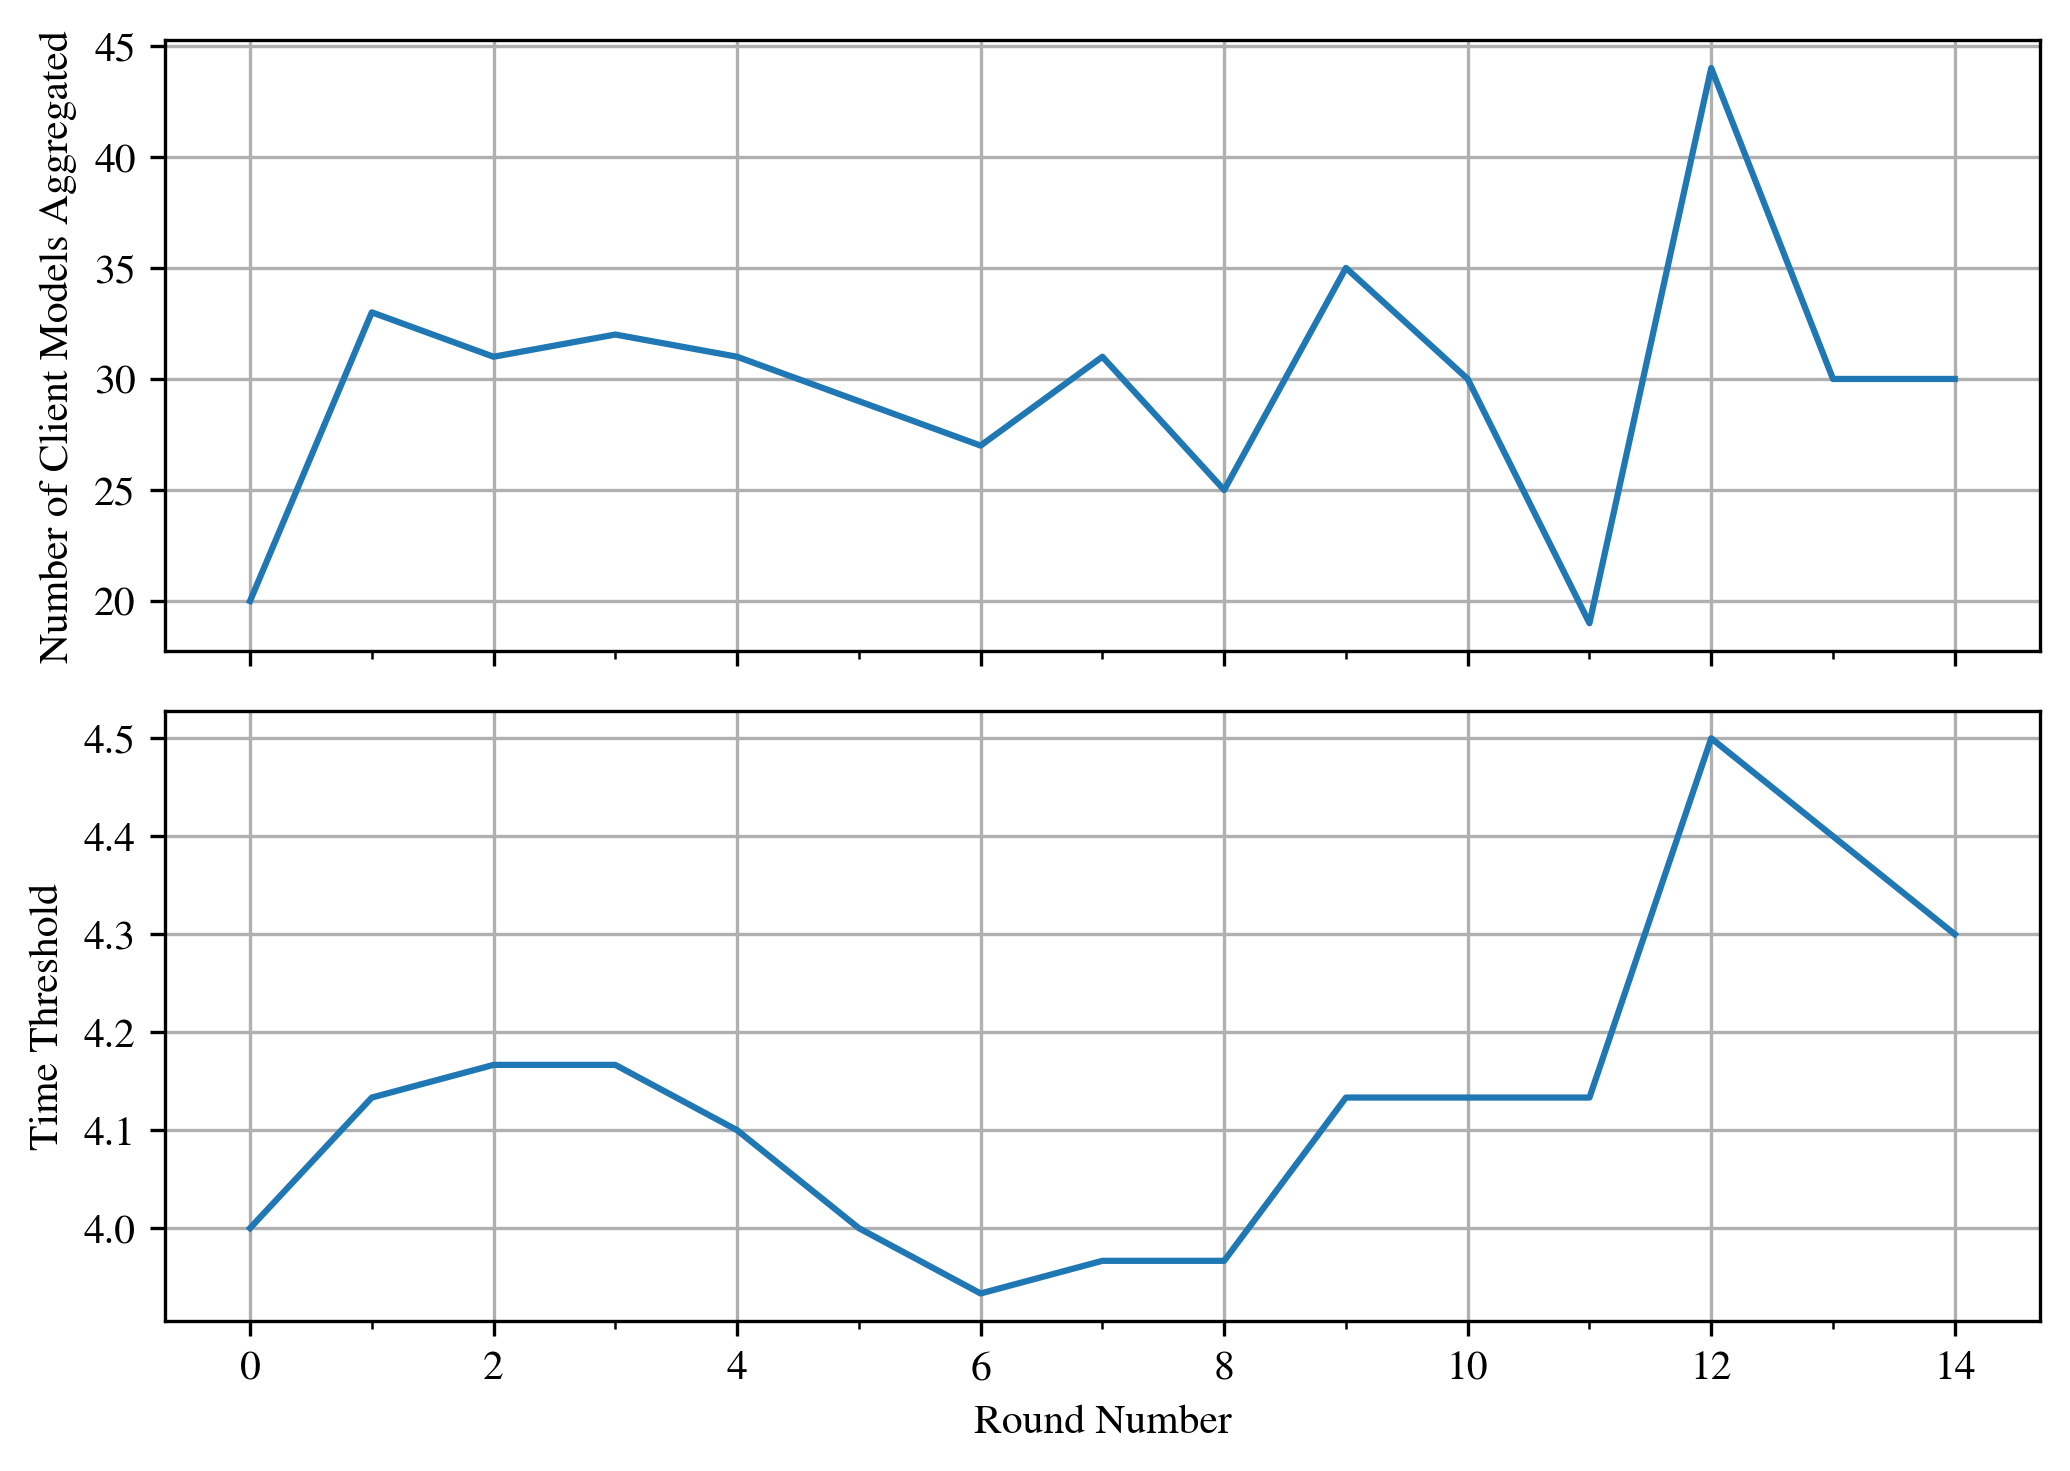

In [72]:
fig = plt.figure(dpi=300, figsize=(7, 5))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax.plot(np.array(serverhist["num processed"])[:-1])
ax.grid()
ax.set_ylabel("Number of Client Models Aggregated")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([])
ax = fig.add_subplot(gs[1, :])
ax.plot(serverhist["time threshold"][:-1])
ax.grid()
ax.set_ylabel("Time Threshold")
ax.set_xlabel("Round Number")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.tight_layout()
plt.savefig("resources/training_times.", dpi=300)
plt.savefig("resources/training_times.pdf", dpi=300)
plt.show()

### Performance of the server model after each round

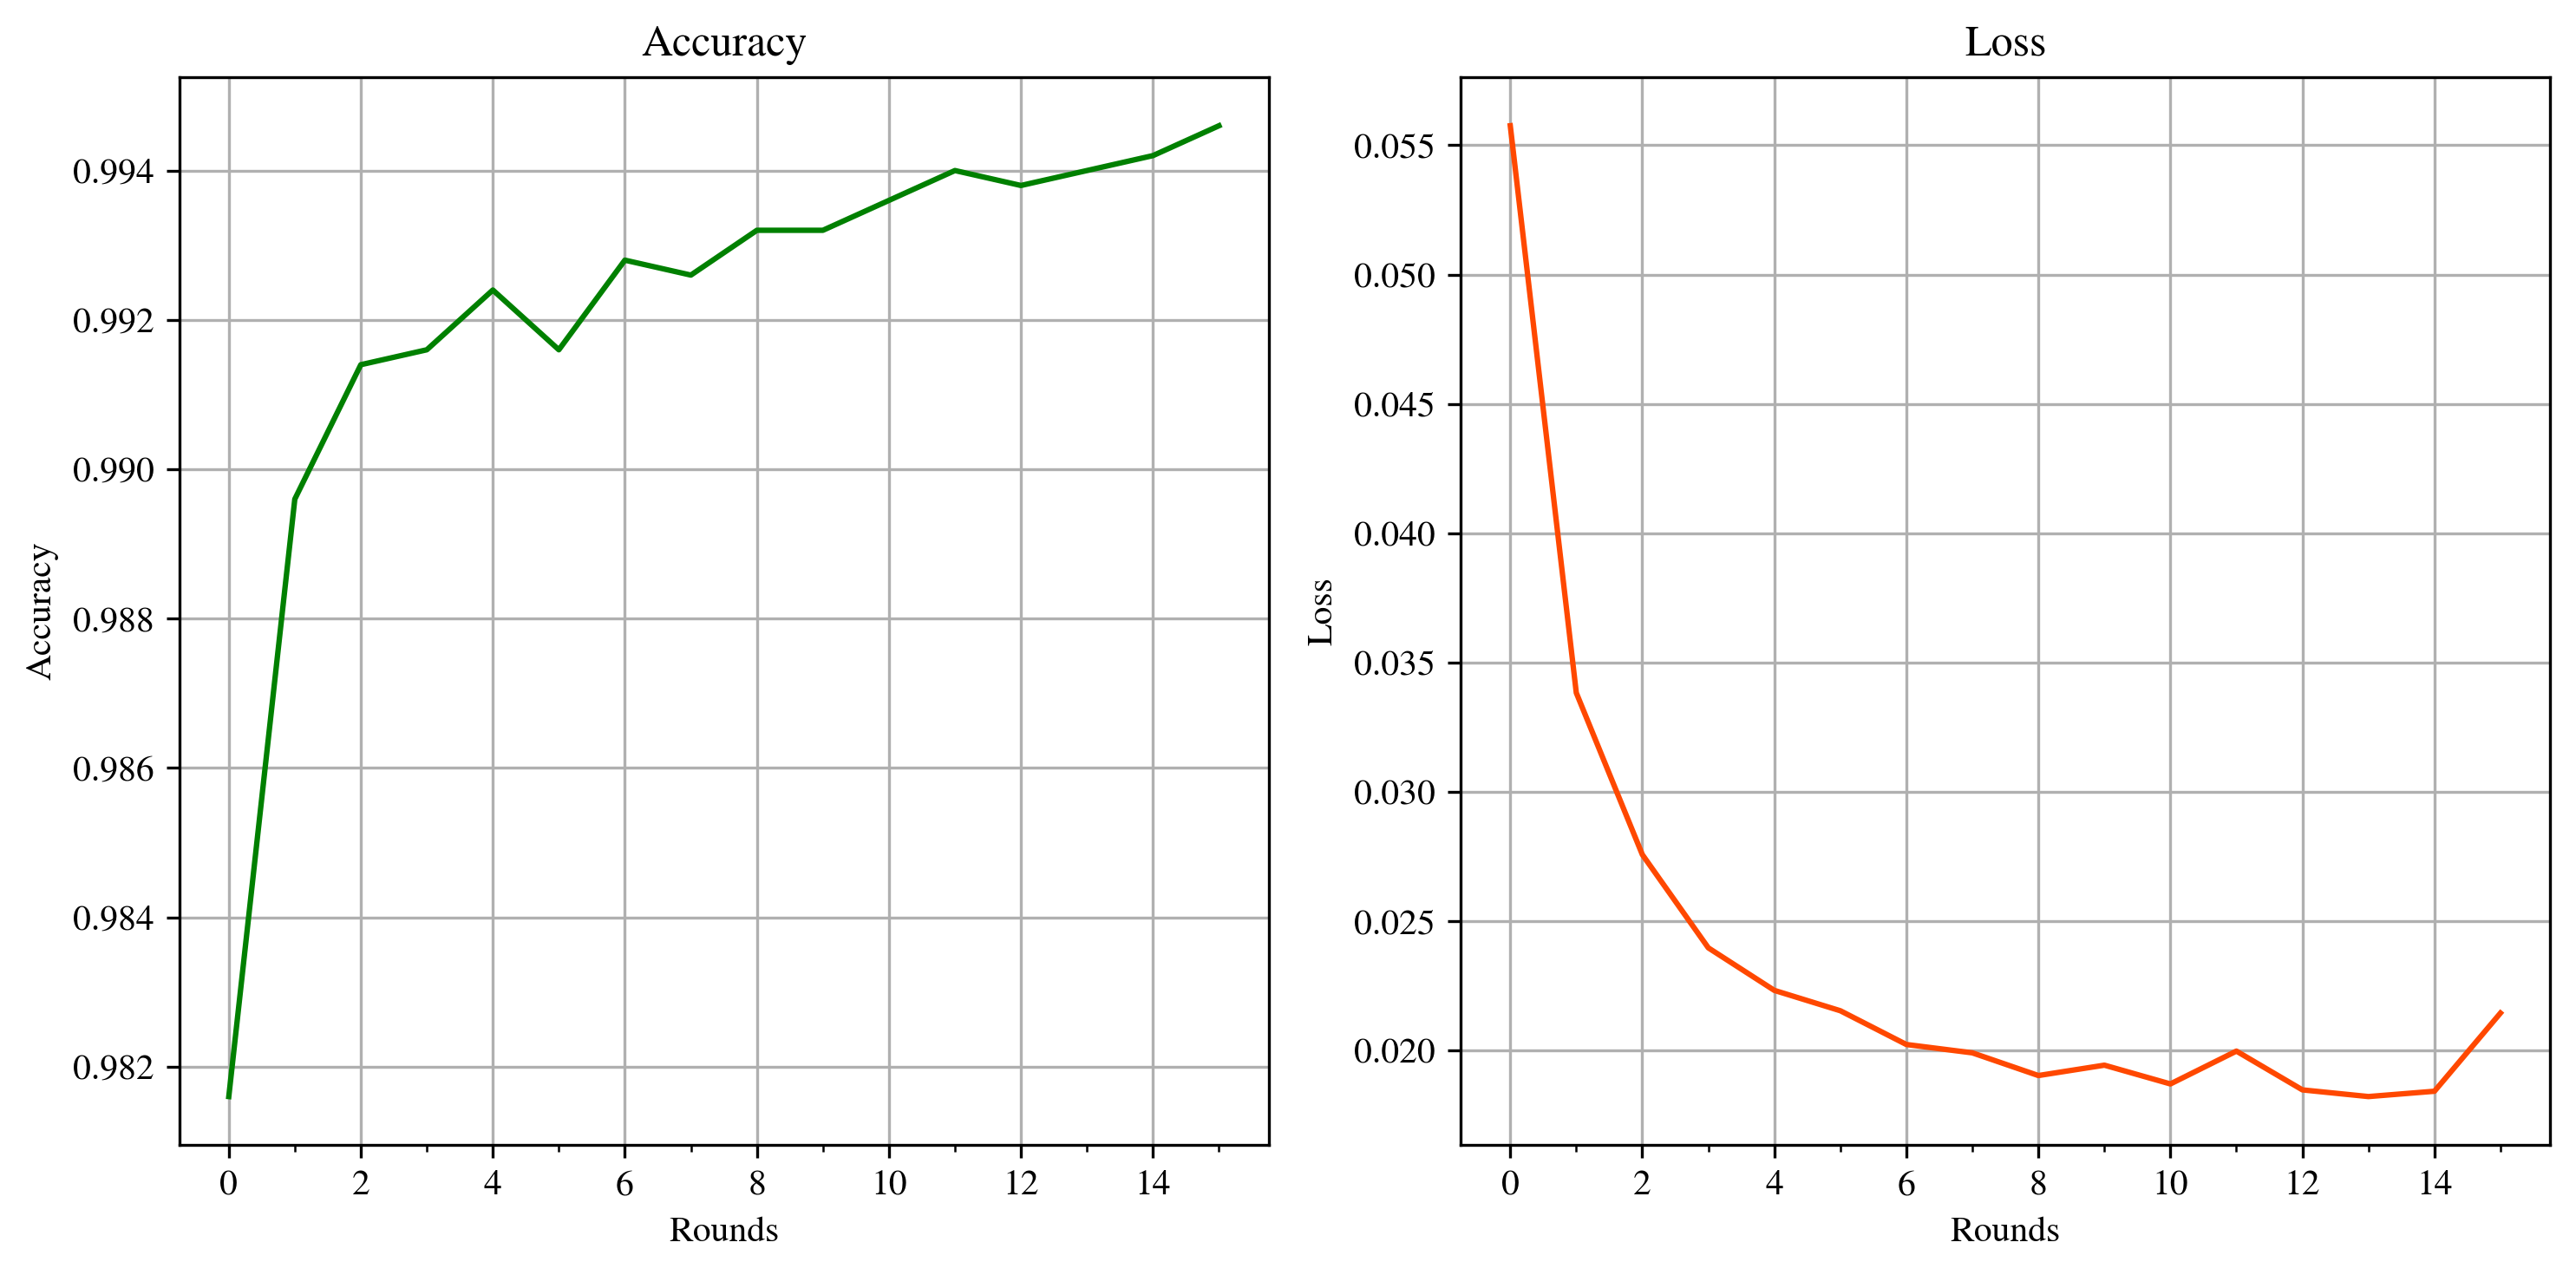

In [63]:
fig = plt.figure(dpi=300, figsize=(10, 5))
ax = fig.add_subplot(121)
ax.plot(serverhist["accuracy"], color='green')
ax.grid()
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax = fig.add_subplot(122)
ax.plot(serverhist["loss"], color='#FF4800')
ax.grid()
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Loss")
ax.set_title("Loss")
plt.tight_layout()
plt.savefig("resources/performance.png", dpi=300)
plt.savefig("resources/performance.pdf", dpi=300)
plt.show()

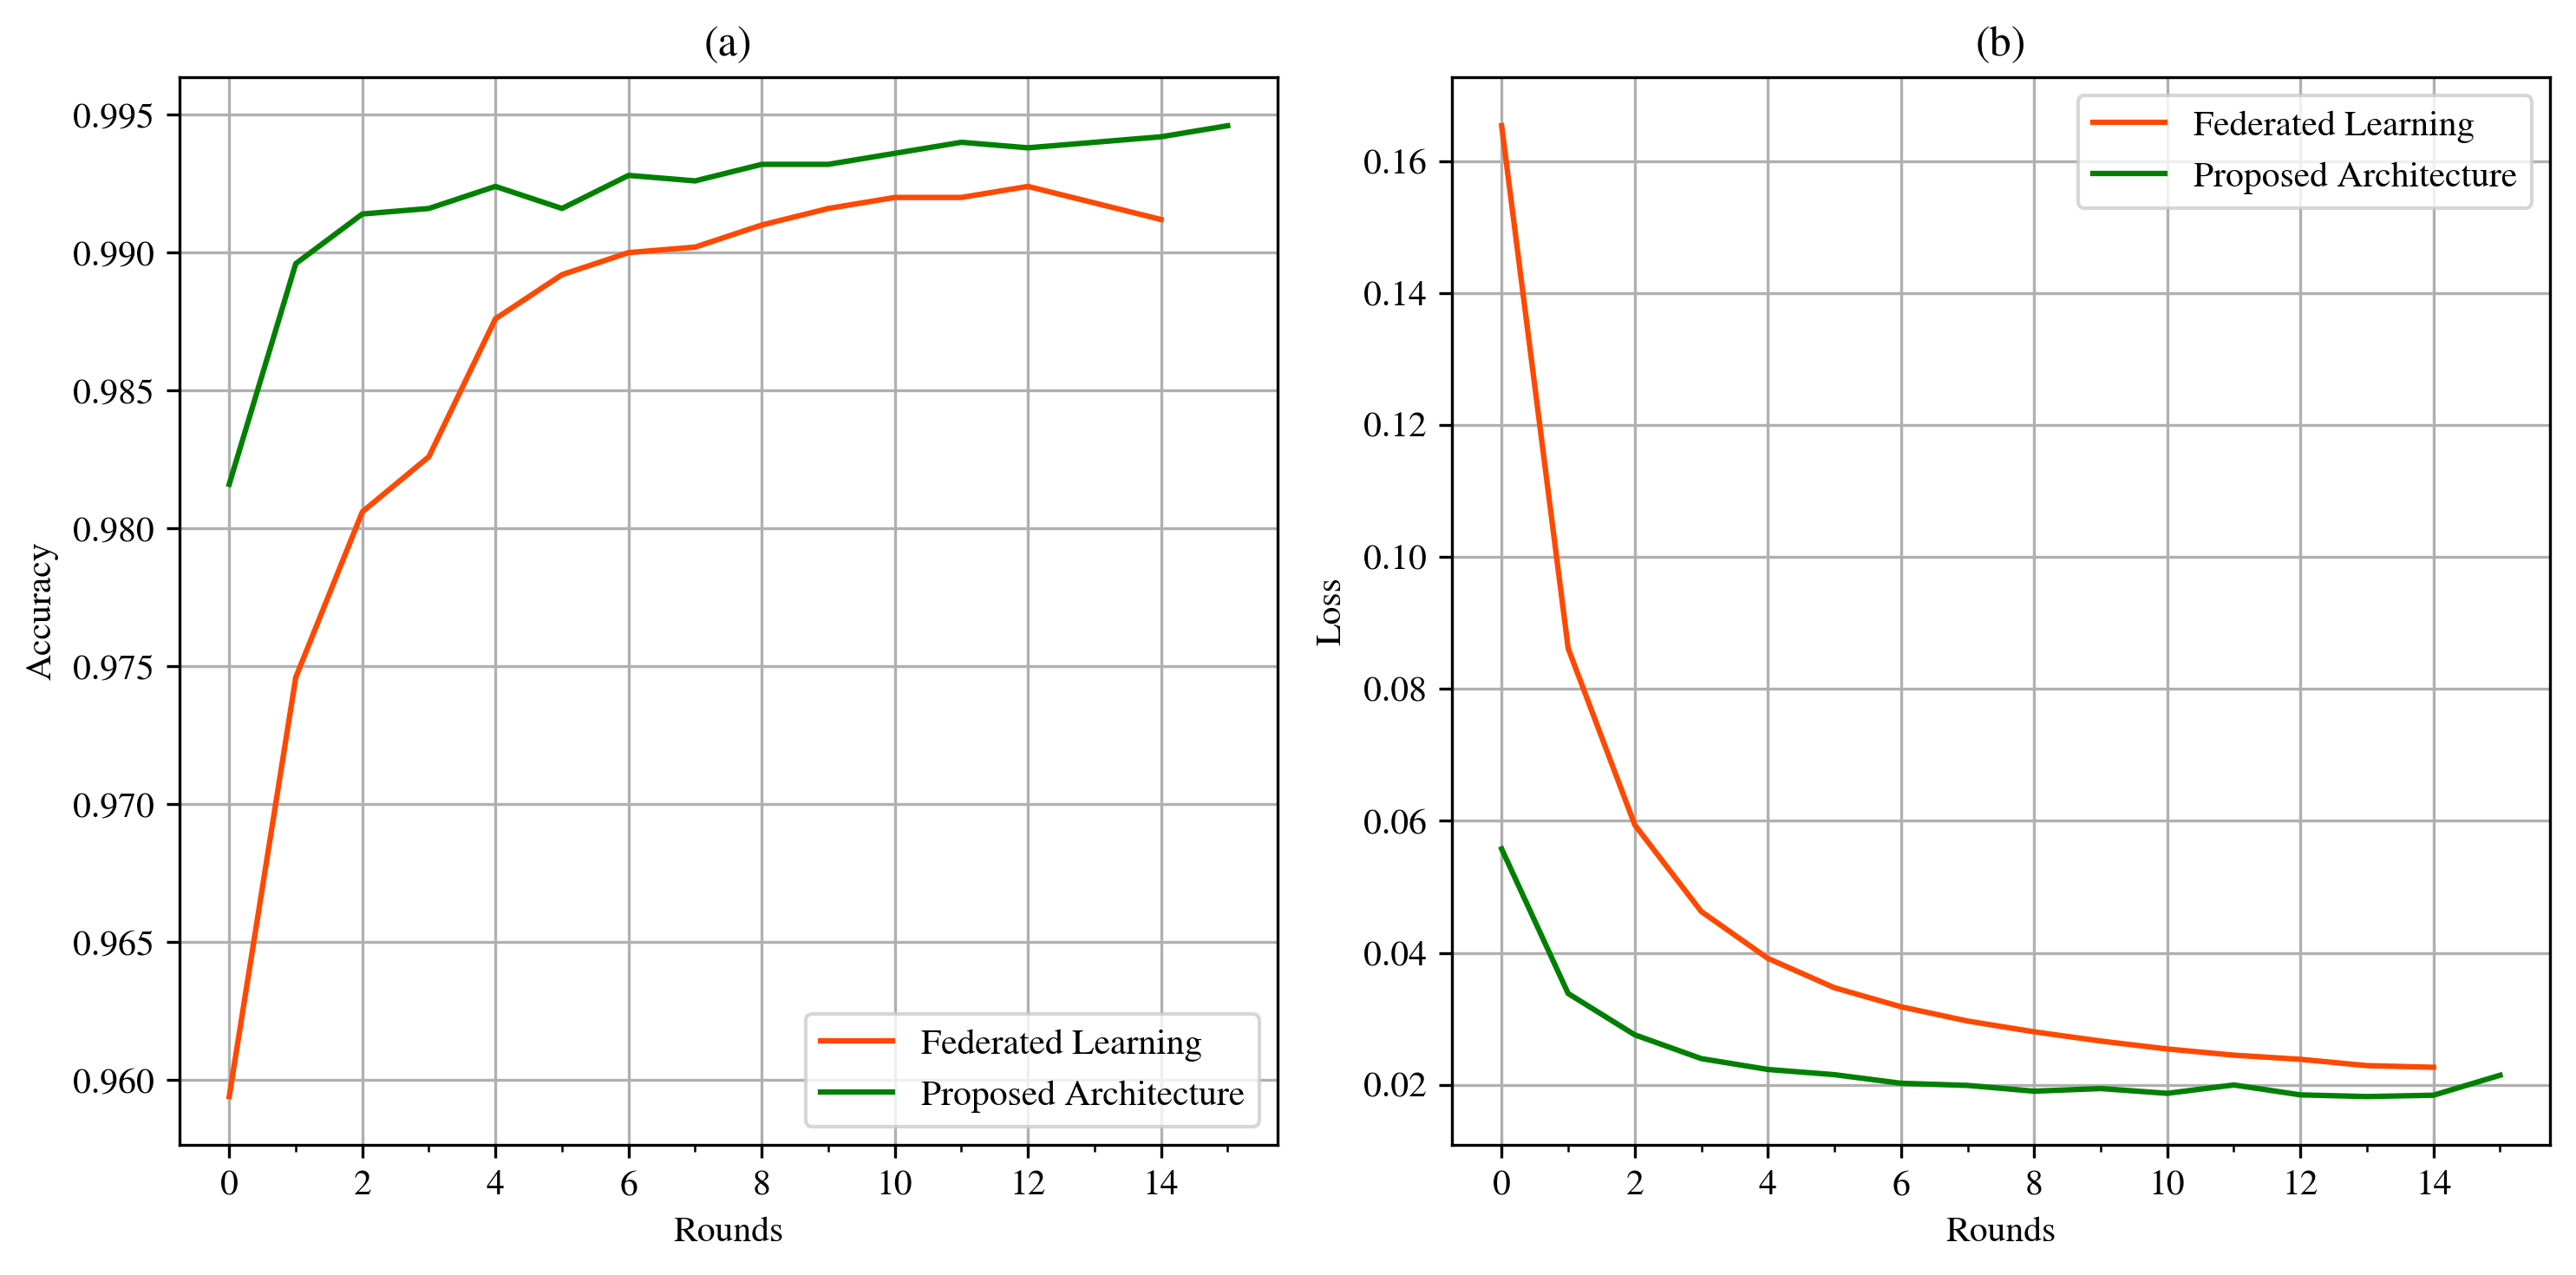

In [67]:
fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.add_subplot(121)
ax.plot(serverhist1["accuracy"], label="Federated Learning", color="#FF4800")
ax.plot(serverhist["accuracy"], label="Proposed Architecture", color="green")
ax.grid(True)
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Accuracy")
ax.set_title("(a)")
ax.legend()
ax = fig.add_subplot(122)
ax.plot(serverhist1["loss"], label="Federated Learning", color="#FF4800")
ax.plot(serverhist["loss"], label="Proposed Architecture", color="green")
ax.grid(True)
ax.set_xlabel("Rounds")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Loss")
ax.set_title("(b)")
ax.legend()
plt.tight_layout()
plt.savefig("resources/comp_performance.png", dpi=300)
plt.savefig("resources/comp_performance.pdf", dpi=300)

In [21]:
sum(serverhist1["time taken"])

69.05948561601318

In [29]:
sum(serverhist["time threshold"][:-1])

62.03333333333334

In [23]:
np.argmax(Y_train, axis=1).shape

(125973,)

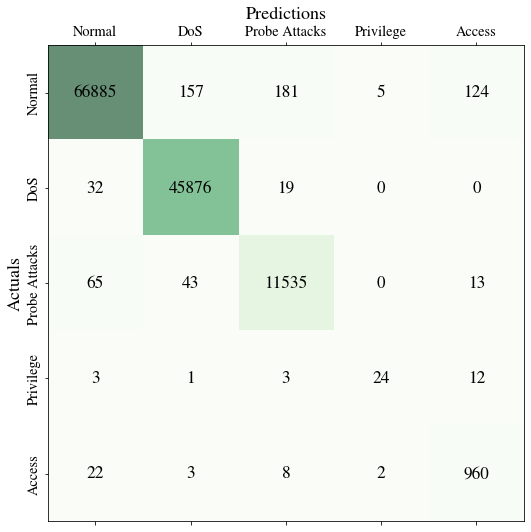

In [66]:
conf_matrix = confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(server_model_norm.predict(X_train), axis=1)).numpy()
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap="Greens", alpha=0.6, vmin=-1000)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(["Normal", "DoS", "Probe Attacks", "Privilege", "Access"], size='x-large')
ax.set_yticklabels(["Normal", "DoS", "Probe Attacks", "Privilege", "Access"], rotation=90, va="center", size='x-large')
plt.ylabel('Actuals', fontsize=18)
plt.title('Predictions', fontsize=18)
plt.tight_layout()
plt.savefig("resources/Confusion_Matrix.png", dpi=300)
plt.savefig("resources/Confusion_Matrix.pdf", dpi=300)
plt.show()

In [75]:
30*15/sum(serverhist1["time taken"][:-1])

KeyError: 'time threshold'